In [5]:
from google.cloud import bigquery
import pandas as pd
from google.oauth2 import service_account
from tqdm.notebook import tqdm

In [6]:
credentials = service_account.Credentials.from_service_account_file('C:\\Users\\elija\\Documents\\24f-coop\\credentials.json')
project = 'net-data-viz-handbook'
# Initialize a GCS client
client = bigquery.Client(credentials=credentials, project=project)

In [12]:
def execute(client, query):
    # Execute query
    query_job = client.query(query)

    # Convert result to a Pandas DataFrame
    result_df = query_job.result().to_dataframe()

    return result_df

## Simplifying a multi-run table

In [4]:
table_name = 'importation_data.h1n1_proper' # str, name of bigquery table
destination = 'importation_data.h1n1_proper_simple' # str, name of place where simplified table will be stored

method = 'mbd' # mbd, directional, or ftvariance

source_column = 'source_basin' # str, name of col holding source ids
target_column = 'target_basin' # str, name of col holding target ids
value_column = 'importations' # str, name of col holding values
compartment_column = 'compartment' # str, name of col holding compartment information

In [5]:
directional = f"""WITH run_direction AS (
    SELECT
        run_id,
        date,
        {value_column},
        CASE
            WHEN {value_column} > LAG({value_column}) OVER(PARTITION BY run_id, {source_column}, {target_column}, {compartment_column} ORDER BY date) THEN 1
            WHEN {value_column} < LAG({value_column}) OVER(PARTITION BY run_id, {source_column}, {target_column}, {compartment_column} ORDER BY date) THEN -1
            ELSE 0
        END AS direction
    FROM
        `{table_name}`
), median_run_id AS (
    SELECT
        run_id,
        VARIANCE(direction) AS direction_variance
    FROM run_direction
    WHERE previous_value IS NOT NULL
    GROUP BY run_id
    ORDER BY direction_variance ASC
    LIMIT 1
    )
        """

In [6]:
mbd = f"""
WITH cume_dist AS (
    SELECT 
        run_id, 
        date,
        CUME_DIST() OVER(PARTITION BY date, {source_column}, {target_column}, {compartment_column} ORDER BY {value_column} ASC) AS rank_asc,
        CUME_DIST() OVER(PARTITION BY date, {source_column}, {target_column}, {compartment_column} ORDER BY {value_column} DESC) AS  rank_desc
    FROM `{table_name}`
), median_run_id AS (
    SELECT
        run_id,
        SUM(rank_asc) * SUM(rank_desc) as mbd
    FROM cume_dist
    GROUP BY run_id
    ORDER BY mbd DESC
    LIMIT 1
)
"""

In [7]:
mbd

'\nWITH cume_dist AS (\n    SELECT \n        run_id, \n        date,\n        CUME_DIST() OVER(PARTITION BY date, source_basin, target_basin, compartment ORDER BY importations ASC) AS rank_asc,\n        CUME_DIST() OVER(PARTITION BY date, source_basin, target_basin, compartment ORDER BY importations DESC) AS  rank_desc\n    FROM `importation_data.h1n1_proper`\n), median_run_id AS (\n    SELECT\n        run_id,\n        SUM(rank_asc) * SUM(rank_desc) as mbd\n    FROM cume_dist\n    GROUP BY run_id\n    ORDER BY mbd DESC\n    LIMIT 1\n)\n'

In [8]:
ftvariance = f"""WITH run_variability AS (
    SELECT
        run_id,
        VARIANCE({value_column}) AS run_variance
    FROM
        `{table_name}`
    GROUP BY
        run_id, {source_column}, {target_column}, {compartment_column}
), median_run_id AS (
    SELECT
        run_id,
        SUM(run_variance)
    FROM
        run_variability
    GROUP BY run_id
    ORDER BY
        run_variance ASC
    LIMIT 1 )
        """

In [9]:
medians = {'ftvariance': ftvariance, 'mbd': mbd, 'directional':directional}

In [10]:
cent_query = f"""
CREATE OR REPLACE TABLE `{destination}` AS
{medians[method]}
SELECT 
    run_id,
    {source_column},
    {target_column}, 
    compartment, 
    {value_column}, 
    date
FROM
    `{table_name}`
WHERE
    run_id = (SELECT run_id FROM median_run_id);
"""

In [11]:
cent_query

'\nCREATE OR REPLACE TABLE `importation_data.h1n1_proper_simple` AS\n\nWITH cume_dist AS (\n    SELECT \n        run_id, \n        date,\n        CUME_DIST() OVER(PARTITION BY date, source_basin, target_basin, compartment ORDER BY importations ASC) AS rank_asc,\n        CUME_DIST() OVER(PARTITION BY date, source_basin, target_basin, compartment ORDER BY importations DESC) AS  rank_desc\n    FROM `importation_data.h1n1_proper`\n), median_run_id AS (\n    SELECT\n        run_id,\n        SUM(rank_asc) * SUM(rank_desc) as mbd\n    FROM cume_dist\n    GROUP BY run_id\n    ORDER BY mbd DESC\n    LIMIT 1\n)\n\nSELECT \n    run_id,\n    source_basin,\n    target_basin, \n    compartment, \n    importations, \n    date\nFROM\n    `importation_data.h1n1_proper`\nWHERE\n    run_id = (SELECT run_id FROM median_run_id);\n'

In [12]:
# create and save simplified table
execute(client, cent_query)

""


In [13]:
mean_query = f"""
CREATE OR REPLACE TABLE `{destination}` AS 
SELECT 
    {source_column},
    {target_column}, 
    {compartment_column}, 
    AVG({value_column}) AS {value_column}, 
    date
FROM
    `{table_name}`
GROUP BY run_id, 
    {source_column},
    {target_column}, 
    {compartment_column},
    date
"""

In [14]:
median_query = f"""
CREATE OR REPLACE TABLE `{destination}` AS
SELECT 
    {source_column},
    {target_column}, 
    {compartment_column}, 
    PERCENTILE_CONT({value_column}, 0.5) OVER (PARTITION BY {source_column}, {target_column}, {compartment_column}, date) AS {value_column}, 
    date
FROM
    `{table_name}`
"""

In [15]:
df = execute(client, median_query)

## Aggregating a single run table by compartment, date

In [16]:
def build_geographic_filter(geo_level: str, geo_values, alias: str = "g_target") -> str:
    """Builds a geographic filter based on the provided level and values."""
    if geo_values is not None:  # Only filter if geo_values is provided
        if isinstance(geo_values, list):
            if isinstance(geo_values[0], int):
                values = ', '.join(str(val) for val in geo_values)  # For INT64
                return f"{alias}.{geo_level} IN ({values})"
            elif isinstance(geo_values[0], str):
                values = ', '.join(f"'{val}'" for val in geo_values)  # For STRING
                return f"{alias}.{geo_level} IN ({values})"
        else:
            if isinstance(geo_values, int):
                return f"{alias}.{geo_level} = {geo_values}"
            elif isinstance(geo_values, str):
                return f"{alias}.{geo_level} = '{geo_values}'"
    return ""  # Return empty string if no filtering is needed

def build_categorical_filter(categories, category_col: str = 'compartment', alias: str = "t") -> str:
    if categories is not None:  # Only filter if geo_values is provided
        if isinstance(categories, list):
            if isinstance(categories[0], int):
                values = ', '.join(str(val) for val in categories)  # For INT64
                return f"{alias}.{category_col} IN ({values})"
            elif isinstance(categories[0], str):
                values = ', '.join(f"'{val}'" for val in categories)  # For STRING
                return f"{alias}.{category_col} IN ({values})"
        else:
            if isinstance(categories, int):
                return f"{alias}.{category_col} = {categories}"
            elif isinstance(categories, str):
                return f"{alias}.{category_col} = '{categories}'"
    return ""  # Return empty string if no filtering is needed

In [42]:
table_name = 'importation_data.h1n1_proper_simple' # str, more than likely `destination` from last query
destination = 'importation_data.h1n1_proper_simple_agg' # str

# all ported over from above
source_column = 'source_basin' # str, name of col holding source ids
target_column = 'target_basin' # str, name of col holding target ids
value_column = 'importations' # str, name of col holding values

# date information
date = 'iso'

# compartment information
compartments = ['Infectious_Asymp', 'Infectious_SympT'] # list, or None to include all
new_compartment = 'Infectious' # str, or None

In [28]:
from epiweeks import Week
from datetime import date as ddate

In [29]:
import epidemic_intelligence as ei

In [45]:
cat_filter = build_categorical_filter(compartments, category_col=compartment_column, alias='t') if compartments is not None else "TRUE"
where_clauses = [cat_filter]
where_clause = " AND ".join(where_clauses)

if date in ['date', 'iso']:
    agg_query = f"""
    CREATE OR REPLACE TABLE `{destination}` AS
    SELECT
        {source_column},
        {target_column}, 
        {f"'{new_compartment}' AS compartment," if isinstance(new_compartment, str) else ''}
        SUM({value_column}) as {value_column}, 
        {"CAST(EXTRACT(ISOYEAR FROM date) AS STRING) || 'W' || LPAD(CAST(EXTRACT(ISOWEEK FROM date) AS STRING), 2, '0')" if date=='iso' else 't.date'} AS date
    FROM
        `{table_name}` AS t
    WHERE
        {where_clause}
    GROUP BY
        {source_column},
        {target_column}, 
        {'compartment, ' if isinstance(new_compartment, str) else ''}
        date
    """
    execute(client, agg_query)

elif date == 'epi':
    epiweek_dict = {}
    for year in range(1950, 2100):
        for month in range(1, 13):
            for day in range (1, 32):
                try:
                    # epiweek_dict[f'{year:04d}-{month:02d}-{day:02d}'] = Week.fromdate(ddate(year, month, day)).cdcformat()
                    epiweek_dict[ddate(year, month, day)] = Week.fromdate(ddate(year, month, day)).cdcformat()
                except(ValueError):
                    pass

    tn = pd.DataFrame(epiweek_dict, index=['epiweek']).T.reset_index(names='date')
    epitable = table_name.split('.')[0] + '.' + ei.helper.generate_random_hash()
    client.load_table_from_dataframe(tn, epitable).result()
    
    agg_query = f"""
        CREATE OR REPLACE TABLE `{destination}` AS
        SELECT
            t.{source_column},
            t.{target_column}, 
            {f"'{new_compartment}' AS compartment," if isinstance(new_compartment, str) else ''}
            SUM(t.{value_column}) as {value_column}, 
            e.epiweek AS date
        FROM
            `{table_name}` AS t
        JOIN
            `{epitable}` AS e ON e.date = t.date
        WHERE
            {where_clause}
        GROUP BY
            t.{source_column},
            t.{target_column}, 
            {'compartment, ' if isinstance(new_compartment, str) else ''}
            date
        """
    
    execute(client, agg_query)
    client.delete_table(epitable, not_found_ok=True)

In [35]:
agg_query

"\n    CREATE OR REPLACE TABLE `importation_data.h1n1_proper_simple_agg` AS\n    SELECT\n        source_basin,\n        target_basin, \n        'Infectious' AS compartment,\n        SUM(importations) as importations, \n        CAST(EXTRACT(ISOYEAR FROM date) AS STRING) || 'W' || LPAD(CAST(EXTRACT(ISOWEEK FROM date) AS STRING), 2, '0') AS date\n    FROM\n        `importation_data.h1n1_proper_simple` AS t\n    WHERE\n        t.compartment IN ('Infectious_Asymp', 'Infectious_SympT')\n    GROUP BY\n        source_basin,\n        target_basin, \n        compartment, \n        date\n    "

# For sir data

In [18]:
def aggregate_sir(client, table_name, destination, 
                    geo_column, value_columns,  run_id_column = 'run_id',
                    date='date'):
    
    if isinstance(value_columns, str):
        value_columns = [value_columns]
    agg_values = ", ".join([f"SUM({col}) AS {col}" for col in value_columns])
    
    if date in ['date', 'iso']:
        agg_query = f"""
        CREATE OR REPLACE TABLE `{destination}` AS
        SELECT
            {run_id_column} AS run_id, 
            {geo_column} AS {geo_column}, 
            {agg_values},
            {"CAST(EXTRACT(ISOYEAR FROM date) AS STRING) || 'W' || LPAD(CAST(EXTRACT(ISOWEEK FROM date) AS STRING), 2, '0')" if date=='iso' else 't.date'} AS date
        FROM
            `{table_name}` AS t
        GROUP BY
            run_id,
            {geo_column},
            date
        """
        execute(client, agg_query)

    elif date == 'epi':
        epiweek_dict = {}
        for year in range(1950, 2100):
            for month in range(1, 13):
                for day in range (1, 32):
                    try:
                        # epiweek_dict[f'{year:04d}-{month:02d}-{day:02d}'] = Week.fromdate(ddate(year, month, day)).cdcformat()
                        epiweek_dict[ddate(year, month, day)] = Week.fromdate(ddate(year, month, day)).cdcformat()
                    except(ValueError):
                        pass

        tn = pd.DataFrame(epiweek_dict, index=['epiweek']).T.reset_index(names='date')
        epitable = table_name.split('.')[0] + '.' + generate_random_hash()
        client.load_table_from_dataframe(tn, epitable).result()
        
        agg_query = f"""
            CREATE OR REPLACE TABLE `{destination}` AS
            SELECT
                {run_id_column} AS run_id, 
                {geo_column} AS {geo_column}, 
                {agg_values}, 
                e.epiweek AS date
            FROM
                `{table_name}` AS t
            JOIN
                `{epitable}` AS e ON e.date = t.date
            WHERE
                {where_clause}
            GROUP BY
                run_id,
                {geo_column},
                date
            """
        
        execute(client, agg_query)
        client.delete_table(epitable, not_found_ok=True)

In [20]:
aggregate_table(
    client=client, 
    table_name='sri_data.SIR_0_basins_prevalence',
    destination='sri_data.SIR_0_basins_prevalence_agg',
    geo_column='basin_id', 
    value_columns=['Susceptible_18_23', 'Infectious_18_23'],
    date='iso'
)

## Testing with `epidemic-intelligence`

In [58]:
import epidemic_intelligence as ei

#### Area Plot

In [24]:
table_name = 'importation_data.h1n1_proper_simple_agg'
value_column = 'importations' # str, name of col holding values

source_column = 'source_basin' # str, name of col holding source ids
target_column = 'target_basin' # str, name of col holding target ids
output_resolution = 'country_name'

reference_table_name = 'reference.gleam-geo-map'
reference_column = 'basin_id'

source_geo_level = 'continent_label'
source_values = 'North America'
target_geo_level = 'continent_label'
target_values = 'Europe'
domestic = False

cutoff = 0.05

In [25]:
ap_fig = ei.area_plot(client, 
            table_name=table_name, 
            reference_table=reference_table_name,
            source_col=source_column, 
            source_geo_level=source_geo_level,
            source_values=source_values,
            target_col=target_column,
            target_geo_level=target_geo_level,
            target_values=target_values,
            output_resolution=output_resolution,
            value=value_column,
            cutoff=cutoff, 
            domestic=domestic)

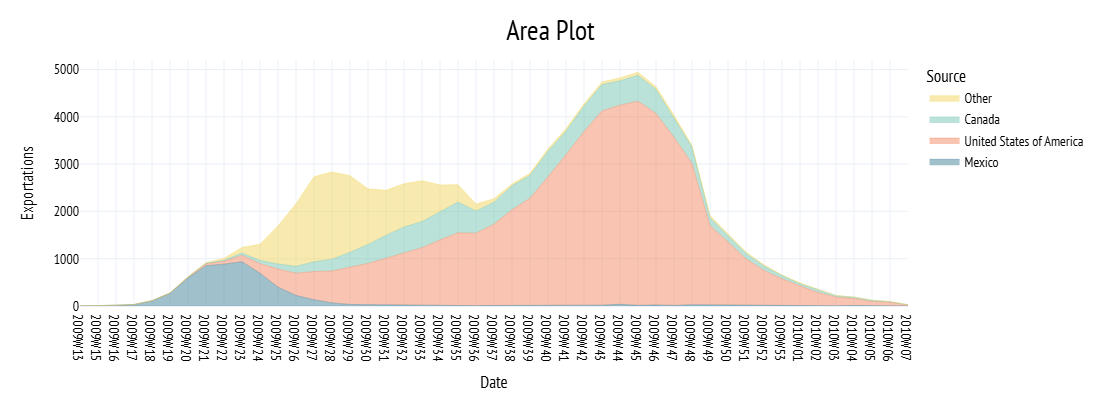

In [43]:
ap_fig.layout.font.family = 'PT Sans Narrow'
ap_fig.update_layout(width=1000, height=400)
ap_fig

In [27]:
date_range = ['2009W19', '2010W04']
cutoff = 0
n = 10

#### Relative Risk

In [28]:
rr_fig = ei.relative_risk(client, 
            table_name=table_name, 
            reference_table=reference_table_name,
            source_col=source_column, 
            source_geo_level=source_geo_level,
            source_values=source_values,
            target_col=target_column,
            target_geo_level=target_geo_level,
            target_values=target_values,
            target_resolution=output_resolution,
            value=value_column,
            date_range=date_range,
            cutoff=cutoff, 
            n=n,
            domestic=domestic)

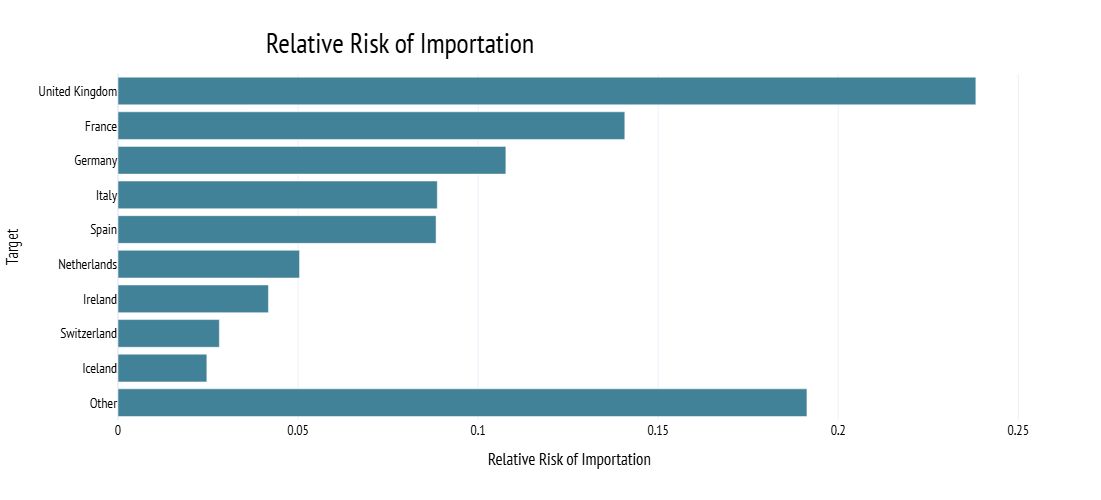

In [45]:
rr_fig.layout.font.family = 'PT Sans Narrow'
rr_fig.update_layout(width=800, height=500)
rr_fig

#### Sankey

In [30]:
n_sources = 4

In [31]:
s_fig = ei.sankey(client, 
                  table_name=table_name,
                  reference_table=reference_table_name,
                  source_geo_level=source_geo_level,
                  target_geo_level=target_geo_level,
                  source_values=source_values,
                  target_values=target_values,
                  date_range=date_range,
                  value=value_column,
                  cutoff=0.05,
                  source_resolution=output_resolution,
                  target_resolution=output_resolution,
                  n_sources=n_sources,
                  n_targets=n

                 )

In [32]:
s_fig.layout.font.family = 'PT Sans Narrow'
s_fig.update_layout(width=500, height=1000)
s_fig.layout.title.y = .9

# recent nicole updates
s_fig.data[0].link.color = 'rgba(221, 219, 215, .6)'
s_fig

## Testing mse, variance, and mbd

In [43]:
import seaborn as sns
import plotly.express as px

In [84]:
q1 = f"""
WITH cume_dist AS (
    SELECT 
        run_id, 
        date,
        CUME_DIST() OVER(PARTITION BY date, {source_column}, {target_column}, {compartment_column} ORDER BY {value_column} ASC) AS rank_asc,
        CUME_DIST() OVER(PARTITION BY date, {source_column}, {target_column}, {compartment_column} ORDER BY {value_column} DESC) AS  rank_desc
    FROM `importation_data.h1n1_proper`
)
SELECT
    run_id,
    SUM(rank_asc) * SUM(rank_desc) as mbd
FROM cume_dist
GROUP BY run_id
ORDER BY mbd DESC
"""

In [85]:
df1 = execute(client, q1)

In [91]:
q2 = f"""
WITH run_variability AS (
    SELECT
        run_id,
        VARIANCE(importations) AS ft_variance
    FROM
        `importation_data.h1n1_proper`
    GROUP BY
        run_id, {source_column}, {target_column}, {compartment_column}
)
    SELECT
        run_id,
        SUM(ft_variance) AS ft_variance
    FROM
        run_variability
    GROUP BY run_id
    ORDER BY
        ft_variance DESC

"""

In [92]:
df2 = execute(client, q2)

In [93]:
q3 = f"""
WITH run_direction AS (
    SELECT
        run_id,
        date,
        importations,
        LAG(importations) OVER(PARTITION BY run_id ORDER BY date) AS previous_importation,
        CASE
            WHEN importations > LAG(importations) OVER(PARTITION BY run_id, {source_column}, {target_column}, {compartment_column} ORDER BY date) THEN 1
            WHEN importations < LAG(importations) OVER(PARTITION BY run_id, {source_column}, {target_column}, {compartment_column} ORDER BY date) THEN -1
            ELSE 0
        END AS direction
    FROM
        `importation_data.h1n1_proper`
)
    SELECT
        run_id,
        VARIANCE(direction) AS direction_variance
    FROM
        run_direction
    WHERE
        previous_importation IS NOT NULL
    GROUP BY
        run_id
        """

In [94]:
df3 = execute(client, q3)

In [95]:
cdf = pd.merge(df1, df2)
cdf = pd.merge(cdf, df3)
cdf.set_index('run_id', inplace=True)

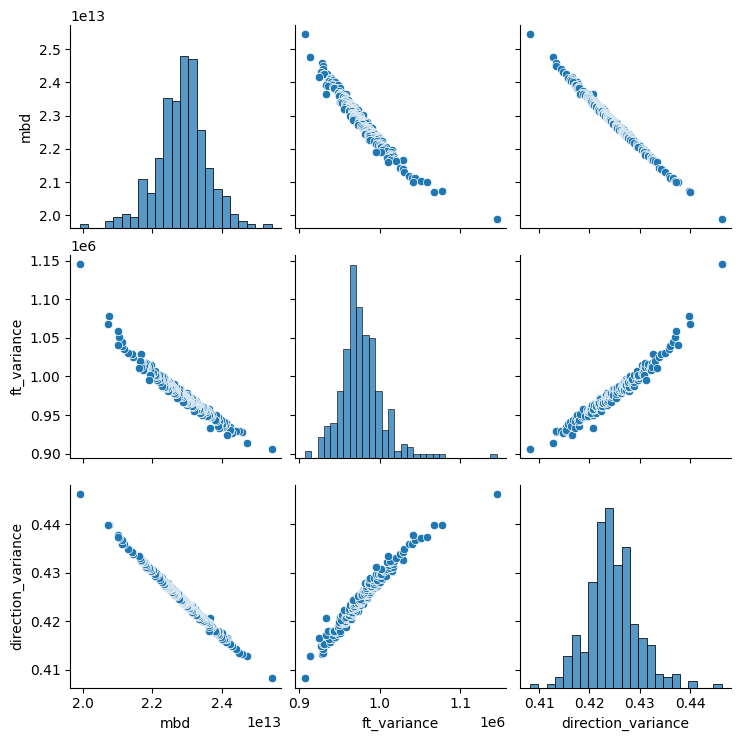

In [96]:
sns.pairplot(cdf)
plt.savefig("avg_calculations.png")

In [103]:
cdf.corr()

,mbd,ft_variance,direction_variance
mbd,1.000000,-0.973759,-0.997808
ft_variance,-0.973759,1.000000,0.974914
direction_variance,-0.997808,0.974914,1.000000
